In [1]:
import numpy as np
import random

import cognitive_GLVQ as cglvq
import cognitive_GLVQ2 as cglvq2
import GLVQ as glvq
import optimizer as opt

# Dictionary

features : narray = (
    feature 1,
    feature 2,
    ...
)

labels : narray = (
    label 1,
    label 2,
    ...
)

classes = {
    "wo": 0,
    "Ak": 1,
    "Al": 2,
    "Mk": 3,
    "Ml": 4,
    "Gk": 5,
    "Gl": 6,
    "ud": 7
}

# Normal vs. Abnormal

In [2]:
num_epochs = 100
num_prototypes = 5
feature_dir = "dataset/feature/inputs_wo_ud_wo_sp_f.npy"
label_dir = "dataset/label/labels_wo_ud.npy"

## data preparation

In [3]:
features = np.load(feature_dir)
labels = np.load(label_dir)
labels = labels.astype(int)
labels = np.where(labels == 0, labels, 1) # Divides the labels into normal(0) and abnormal(1)

# class counts
unique, count = np.unique(labels, return_counts=True)
dict(zip(unique, count))

{0: 1007, 1: 479}

### Prototype selection

In [4]:

# Prototype selection
index_normal = np.where(labels == 0)
index_normal = list(index_normal[0])
index_abnormal = np.where(labels == 1)
index_abnormal = list(index_abnormal[0])

## Random prototype selection
prototype_normal_index = random.sample(index_normal, num_prototypes)
prototype_abnormal_index = random.sample(index_abnormal, num_prototypes)
prototypes_index = prototype_normal_index + prototype_abnormal_index
prototypes_index.sort(reverse=True)

prototypes = [(features[i],labels[i]) for i in prototypes_index]

## Remove prototypes from dataset
features = np.delete(features, prototypes_index, axis=0)
labels = np.delete(labels, prototypes_index, axis=0)    

#### Accuracy

In [5]:
index_normal = np.where(labels == 0)
index_normal = list(index_normal[0])
index_abnormal = np.where(labels == 1)
index_abnormal = list(index_abnormal[0])

# Select equal amount of normal and abnormal data
data_per_class = min(count) - num_prototypes
index_normal_sample = random.sample(index_normal, data_per_class)
dataset_index = index_normal_sample + index_abnormal
random.shuffle(dataset_index)
dataset_acc = [(features[i],labels[i]) for i in dataset_index]

##### Split test, training set

In [6]:
# Taking 15% of the dataset for testing
len_dataset_acc = len(dataset_acc)
test_size = 0.15
test_set_acc = dataset_acc[:int(len_dataset_acc*test_size)]
train_set_acc = dataset_acc[int(len_dataset_acc*test_size):]

##### training the model

###### GLVQ

In [7]:
learning_rate = 0.3
glvq_acc = glvq.GLVQ(prototypes, learning_rate)
hist = glvq_acc.train(num_epochs, train_set_acc, test_set_acc)

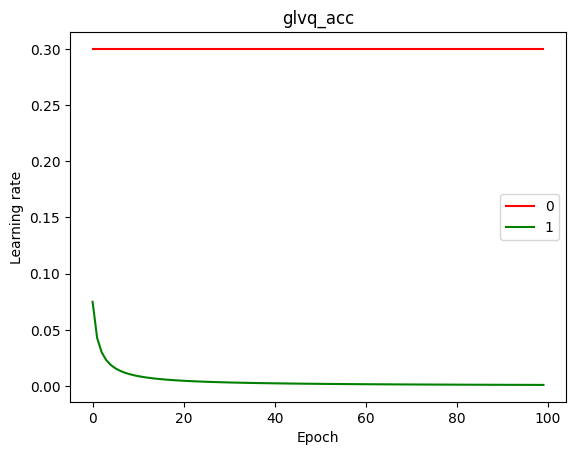

In [8]:
glvq_acc.lr_graph("glvq_acc")

###### CP

In [9]:
cp_glvq_acc = cglvq.CGLVQ(prototypes)
hist = cp_glvq_acc.train(num_epochs, train_set_acc, test_set_acc, opt.conditional_probability)

In [ ]:
cp_glvq_acc.lr_graph("cp_acc")

###### CP 2

In [ ]:
cp_glvq_acc2 = cglvq2.CGLVQ(prototypes,0.3)
hist = cp_glvq_acc2.train(num_epochs, train_set_acc, test_set_acc, opt.conditional_probability)

In [ ]:
cp_glvq_acc2.lr_graph("cp_acc2")

###### LS

In [ ]:
ls_glvq_acc = cglvq.CGLVQ(prototypes)
hist = ls_glvq_acc.train(num_epochs, train_set_acc, test_set_acc, opt.loose_symmetry)

In [ ]:
ls_glvq_acc.lr_graph("ls_acc")

###### LS 2

In [ ]:
ls_glvq_acc2 = cglvq2.CGLVQ(prototypes,0.3)
hist = ls_glvq_acc2.train(num_epochs, train_set_acc, test_set_acc, opt.loose_symmetry)

In [ ]:
ls_glvq_acc2.lr_graph("ls_acc2")

###### LSR

In [ ]:
lsr_glvq_acc = cglvq.CGLVQ(prototypes)
hist = lsr_glvq_acc.train(num_epochs, train_set_acc, test_set_acc, opt.loose_symmetry_rarity)

In [ ]:
lsr_glvq_acc.lr_graph("lsr_acc")

###### LSR 2

In [ ]:
lsr_glvq_acc2 = cglvq2.CGLVQ(prototypes,0.3)
hist = lsr_glvq_acc2.train(num_epochs, train_set_acc, test_set_acc, opt.loose_symmetry_rarity)

In [ ]:
lsr_glvq_acc2.lr_graph("lsr_acc2")

###### DFH

In [ ]:
dfh_glvq_acc = cglvq.CGLVQ(prototypes)
hist = dfh_glvq_acc.train(num_epochs, train_set_acc, test_set_acc, opt.dual_factor_heuristic)

In [ ]:
dfh_glvq_acc.lr_graph("dfh_acc")

###### DFH 2

In [ ]:
dfh_glvq_acc2 = cglvq2.CGLVQ(prototypes,0.3)
hist = dfh_glvq_acc2.train(num_epochs, train_set_acc, test_set_acc, opt.dual_factor_heuristic)

In [ ]:
dfh_glvq_acc2.lr_graph("dfh_acc2")

#### F1_Score

In [ ]:
len_dataset_f1 = len(features)
dataset_f1 = [(features[i],labels[i]) for i in range(len_dataset_f1)]
random.shuffle(dataset_f1)

##### Split test, training set

In [ ]:
# Taking 15% of the dataset for testing
test_size = 0.15
test_set_f1 = dataset_f1[:int(len_dataset_f1*test_size)]
train_set_f1 = dataset_f1[int(len_dataset_f1*test_size):]

##### training the model

###### GLVQ

In [ ]:
learning_rate = 0.3
glvq_f1 = glvq.GLVQ(prototypes, learning_rate)
hist = glvq_f1.train(num_epochs, train_set_f1, test_set_f1)

In [ ]:
glvq_f1.lr_graph("glvq_f1")

###### CP

In [ ]:
cp_glvq_f1 = cglvq.CGLVQ(prototypes)
hist = cp_glvq_f1.train(num_epochs, train_set_f1, test_set_f1, opt.conditional_probability)

In [ ]:
cp_glvq_f1.lr_graph("cp_f1")

###### CP 2

In [ ]:
cp_glvq_f1_2 = cglvq2.CGLVQ(prototypes,0.3)
hist = cp_glvq_f1_2.train(num_epochs, train_set_f1, test_set_f1, opt.conditional_probability)

In [ ]:
cp_glvq_f1_2.lr_graph("cp_f1_2")

###### LS

In [ ]:
ls_glvq_f1 = cglvq.CGLVQ(prototypes)
hist = ls_glvq_f1.train(num_epochs, train_set_f1, test_set_f1, opt.loose_symmetry)

In [ ]:
ls_glvq_f1.lr_graph("ls_f1")

###### LS 2

In [ ]:
ls_glvq_f1_2 = cglvq2.CGLVQ(prototypes,0.3)
hist = ls_glvq_f1_2.train(num_epochs, train_set_f1, test_set_f1, opt.loose_symmetry)

In [ ]:
ls_glvq_f1_2.lr_graph("ls_f1_2")

###### LSR

In [ ]:
lsr_glvq_f1 = cglvq.CGLVQ(prototypes)
hist = lsr_glvq_f1.train(num_epochs, train_set_f1, test_set_f1, opt.loose_symmetry_rarity)

In [ ]:
lsr_glvq_f1.lr_graph("lsr_f1")

###### LSR 2

In [ ]:
lsr_glvq_f1_2 = cglvq2.CGLVQ(prototypes,0.3)
hist = lsr_glvq_f1_2.train(num_epochs, train_set_f1, test_set_f1, opt.loose_symmetry_rarity)

In [ ]:
lsr_glvq_f1_2.lr_graph("lsr_f1_2")

###### DFH

In [ ]:
dfh_glvq_f1 = cglvq.CGLVQ(prototypes)
hist = dfh_glvq_f1.train(num_epochs, train_set_f1, test_set_f1, opt.dual_factor_heuristic)

In [ ]:
dfh_glvq_f1.lr_graph("dfh_f1")

###### DFH 2

In [ ]:
dfh_glvq_f1_2 = cglvq2.CGLVQ(prototypes,0.3)
hist = dfh_glvq_f1_2.train(num_epochs, train_set_f1, test_set_f1, opt.dual_factor_heuristic)

In [ ]:
dfh_glvq_f1_2.lr_graph("dfh_f1_2")

## All Classes

In [ ]:
num_epochs = 100
num_prototypes = 3

#### data preparation

In [ ]:
features = np.load(feature_dir)
labels = np.load(label_dir)
labels = labels.astype(int)

# class counts
unique, count = np.unique(labels, return_counts=True)
dict(zip(unique, count))

In [ ]:

# Random Prototype selection
prototypes_index = []
for i in range(7):
    index_i = np.where(labels == i)
    index_i = list(index_i[0])
    prototype_index_i = random.sample(index_i, num_prototypes)
    prototypes_index += prototype_index_i
prototypes_index.sort(reverse=True)

prototypes = [(features[i],labels[i]) for i in prototypes_index]

## Remove prototypes from dataset
features = np.delete(features, prototypes_index, axis=0)
labels = np.delete(labels, prototypes_index, axis=0)    

##### Accuracy

In [ ]:
# Select equal amount of normal and abnormal data
data_per_class = min(count) - num_prototypes

dataset_index = []
for i in range(7):
    index_i = np.where(labels == i)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, data_per_class)
    dataset_index += index_i_sample

random.shuffle(dataset_index)
dataset_acc = [(features[i],labels[i]) for i in dataset_index]

##### Split test, training set

In [ ]:
# Taking 15% of the dataset for testing
len_dataset_acc = len(dataset_acc)
test_size = 0.15
test_set_acc = dataset_acc[:int(len_dataset_acc*test_size)]
train_set_acc = dataset_acc[int(len_dataset_acc*test_size):]

##### training the model

###### GLVQ

In [ ]:
learning_rate = 0.3
glvq_acc = glvq.GLVQ(prototypes, learning_rate)
hist = glvq_acc.train(num_epochs, train_set_acc, test_set_acc)

In [ ]:
glvq_acc.lr_graph("glvq_acc")

###### CP

In [ ]:
cp_glvq_acc = cglvq.CGLVQ(prototypes)
hist = cp_glvq_acc.train(num_epochs, train_set_acc, test_set_acc, opt.conditional_probability)

In [ ]:
cp_glvq_acc.lr_graph("cp_acc")

###### CP 2

In [ ]:
cp_glvq_acc2 = cglvq2.CGLVQ(prototypes,0.3)
hist = cp_glvq_acc2.train(num_epochs, train_set_acc, test_set_acc, opt.conditional_probability)

In [ ]:
cp_glvq_acc2.lr_graph("cp_acc2")

###### LS

In [ ]:
ls_glvq_acc = cglvq.CGLVQ(prototypes)
hist = ls_glvq_acc.train(num_epochs, train_set_acc, test_set_acc, opt.loose_symmetry)

In [ ]:
ls_glvq_acc.lr_graph("ls_acc")

###### LS 2

In [ ]:
ls_glvq_acc2 = cglvq2.CGLVQ(prototypes,0.3)
hist = ls_glvq_acc2.train(num_epochs, train_set_acc, test_set_acc, opt.loose_symmetry)

In [ ]:
ls_glvq_acc2.lr_graph("ls_acc2")

###### LSR

In [ ]:
lsr_glvq_acc = cglvq.CGLVQ(prototypes)
hist = lsr_glvq_acc.train(num_epochs, train_set_acc, test_set_acc, opt.loose_symmetry_rarity)

In [ ]:
lsr_glvq_acc.lr_graph("lsr_acc")

###### LSR 2

In [ ]:
lsr_glvq_acc2 = cglvq2.CGLVQ(prototypes,0.3)
hist = lsr_glvq_acc2.train(num_epochs, train_set_acc, test_set_acc, opt.loose_symmetry_rarity)

In [ ]:
lsr_glvq_acc2.lr_graph("lsr_acc2")

###### DFH

In [ ]:
dfh_glvq_acc = cglvq.CGLVQ(prototypes)
hist = dfh_glvq_acc.train(num_epochs, train_set_acc, test_set_acc, opt.dual_factor_heuristic)

In [ ]:
dfh_glvq_acc.lr_graph("dfh_acc")

###### DFH 2

In [ ]:
dfh_glvq_acc2 = cglvq2.CGLVQ(prototypes,0.3)
hist = dfh_glvq_acc2.train(num_epochs, train_set_acc, test_set_acc, opt.dual_factor_heuristic)

In [ ]:
dfh_glvq_acc2.lr_graph("dfh_acc2")

#### F1_Score

In [ ]:
len_dataset_f1 = len(features)
dataset_f1 = [(features[i],labels[i]) for i in range(len_dataset_f1)]
random.shuffle(dataset_f1)

##### Split test, training set

In [ ]:
# Taking 15% of the dataset for testing
test_size = 0.15
test_set_f1 = dataset_f1[:int(len_dataset_f1*test_size)]
train_set_f1 = dataset_f1[int(len_dataset_f1*test_size):]

##### training the model

###### GLVQ

In [ ]:
learning_rate = 0.3
glvq_f1 = glvq.GLVQ(prototypes, learning_rate)
hist = glvq_f1.train(num_epochs, train_set_f1, test_set_f1)

In [ ]:
glvq_f1.lr_graph("glvq_f1")

###### CP

In [ ]:
cp_glvq_f1 = cglvq.CGLVQ(prototypes)
hist = cp_glvq_f1.train(num_epochs, train_set_f1, test_set_f1, opt.conditional_probability)

In [ ]:
cp_glvq_f1.lr_graph("cp_f1")

###### CP 2

In [ ]:
cp_glvq_f1_2 = cglvq2.CGLVQ(prototypes,0.3)
hist = cp_glvq_f1_2.train(num_epochs, train_set_f1, test_set_f1, opt.conditional_probability)

In [ ]:
cp_glvq_f1_2.lr_graph("cp_f1_2")

###### LS

In [ ]:
ls_glvq_f1 = cglvq.CGLVQ(prototypes)
hist = ls_glvq_f1.train(num_epochs, train_set_f1, test_set_f1, opt.loose_symmetry)

In [ ]:
ls_glvq_f1.lr_graph("ls_f1")

###### LS 2

In [ ]:
ls_glvq_f1_2 = cglvq2.CGLVQ(prototypes,0.3)
hist = ls_glvq_f1_2.train(num_epochs, train_set_f1, test_set_f1, opt.loose_symmetry)

In [ ]:
ls_glvq_f1_2.lr_graph("ls_f1_2")

###### LSR

In [ ]:
lsr_glvq_f1 = cglvq.CGLVQ(prototypes)
hist = lsr_glvq_f1.train(num_epochs, train_set_f1, test_set_f1, opt.loose_symmetry_rarity)

In [ ]:
lsr_glvq_f1.lr_graph("lsr_f1")

###### LSR 2

In [ ]:
lsr_glvq_f1_2 = cglvq2.CGLVQ(prototypes,0.3)
hist = lsr_glvq_f1_2.train(num_epochs, train_set_f1, test_set_f1, opt.loose_symmetry_rarity)

In [ ]:
lsr_glvq_f1_2.lr_graph("lsr_f1_2")

###### DFH

In [ ]:
dfh_glvq_f1 = cglvq.CGLVQ(prototypes)
hist = dfh_glvq_f1.train(num_epochs, train_set_f1, test_set_f1, opt.dual_factor_heuristic)

In [ ]:
dfh_glvq_f1.lr_graph("dfh_f1")

###### DFH 2

In [ ]:
dfh_glvq_f1_2 = cglvq2.CGLVQ(prototypes,0.3)
hist = dfh_glvq_f1_2.train(num_epochs, train_set_f1, test_set_f1, opt.dual_factor_heuristic)

In [ ]:
dfh_glvq_f1_2.lr_graph("dfh_f1_2")

## Only Sickness

In [ ]:
num_epochs = 100
num_prototypes = 3

#### data preparation

In [ ]:
features = np.load(feature_dir)
labels = np.load(label_dir)
labels = labels.astype(int)

index_normal = np.where(labels == 0)
index_normal = list(index_normal[0])
features = np.delete(features, index_normal, axis=0)
labels = np.delete(labels, index_normal, axis=0)

# class counts
unique, count = np.unique(labels, return_counts=True)
dict(zip(unique, count))

In [ ]:

# Random Prototype selection
prototypes_index = []
for i in range(1,7):
    index_i = np.where(labels == i)
    index_i = list(index_i[0])
    prototype_index_i = random.sample(index_i, num_prototypes)
    prototypes_index += prototype_index_i
prototypes_index.sort(reverse=True)

prototypes = [(features[i],labels[i]) for i in prototypes_index]

## Remove prototypes from dataset
features = np.delete(features, prototypes_index, axis=0)
labels = np.delete(labels, prototypes_index, axis=0)    

##### Accuracy

In [ ]:
# Select equal amount of normal and abnormal data
data_per_class = min(count) - num_prototypes

dataset_index = []
for i in range(1,7):
    index_i = np.where(labels == i)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, data_per_class)
    dataset_index += index_i_sample

random.shuffle(dataset_index)
dataset_acc = [(features[i],labels[i]) for i in dataset_index]

##### Split test, training set

In [ ]:
# Taking 15% of the dataset for testing
len_dataset_acc = len(dataset_acc)
test_size = 0.15
test_set_acc = dataset_acc[:int(len_dataset_acc*test_size)]
train_set_acc = dataset_acc[int(len_dataset_acc*test_size):]

##### training the model

###### GLVQ

In [ ]:
learning_rate = 0.3
glvq_acc = glvq.GLVQ(prototypes, learning_rate)
hist = glvq_acc.train(num_epochs, train_set_acc, test_set_acc)

In [ ]:
glvq_acc.lr_graph("glvq_acc")

###### CP

In [ ]:
cp_glvq_acc = cglvq.CGLVQ(prototypes)
hist = cp_glvq_acc.train(num_epochs, train_set_acc, test_set_acc, opt.conditional_probability)

In [ ]:
cp_glvq_acc.lr_graph("cp_acc")

###### CP 2

In [ ]:
cp_glvq_acc2 = cglvq2.CGLVQ(prototypes,0.3)
hist = cp_glvq_acc2.train(num_epochs, train_set_acc, test_set_acc, opt.conditional_probability)

In [ ]:
cp_glvq_acc2.lr_graph("cp_acc2")

###### LS

In [ ]:
ls_glvq_acc = cglvq.CGLVQ(prototypes)
hist = ls_glvq_acc.train(num_epochs, train_set_acc, test_set_acc, opt.loose_symmetry)

In [ ]:
ls_glvq_acc.lr_graph("ls_acc")

###### LS 2

In [ ]:
ls_glvq_acc2 = cglvq2.CGLVQ(prototypes,0.3)
hist = ls_glvq_acc2.train(num_epochs, train_set_acc, test_set_acc, opt.loose_symmetry)

In [ ]:
ls_glvq_acc2.lr_graph("ls_acc2")

###### LSR

In [ ]:
lsr_glvq_acc = cglvq.CGLVQ(prototypes)
hist = lsr_glvq_acc.train(num_epochs, train_set_acc, test_set_acc, opt.loose_symmetry_rarity)

In [ ]:
lsr_glvq_acc.lr_graph("lsr_acc")

###### LSR 2

In [ ]:
lsr_glvq_acc2 = cglvq2.CGLVQ(prototypes,0.3)
hist = lsr_glvq_acc2.train(num_epochs, train_set_acc, test_set_acc, opt.loose_symmetry_rarity)

In [ ]:
lsr_glvq_acc2.lr_graph("lsr_acc2")

###### DFH

In [ ]:
dfh_glvq_acc = cglvq.CGLVQ(prototypes)
hist = dfh_glvq_acc.train(num_epochs, train_set_acc, test_set_acc, opt.dual_factor_heuristic)

In [ ]:
dfh_glvq_acc.lr_graph("dfh_acc")

###### DFH 2

In [ ]:
dfh_glvq_acc2 = cglvq2.CGLVQ(prototypes,0.3)
hist = dfh_glvq_acc2.train(num_epochs, train_set_acc, test_set_acc, opt.dual_factor_heuristic)

In [ ]:
dfh_glvq_acc2.lr_graph("dfh_acc2")

#### F1_Score

In [ ]:
len_dataset_f1 = len(features)
dataset_f1 = [(features[i],labels[i]) for i in range(len_dataset_f1)]
random.shuffle(dataset_f1)

##### Split test, training set

In [ ]:
# Taking 15% of the dataset for testing
test_size = 0.15
test_set_f1 = dataset_f1[:int(len_dataset_f1*test_size)]
train_set_f1 = dataset_f1[int(len_dataset_f1*test_size):]

##### training the model

###### GLVQ

In [ ]:
learning_rate = 0.3
glvq_f1 = glvq.GLVQ(prototypes, learning_rate)
hist = glvq_f1.train(num_epochs, train_set_f1, test_set_f1)

In [ ]:
glvq_f1.lr_graph("glvq_f1")

###### CP

In [ ]:
cp_glvq_f1 = cglvq.CGLVQ(prototypes)
hist = cp_glvq_f1.train(num_epochs, train_set_f1, test_set_f1, opt.conditional_probability)

In [ ]:
cp_glvq_f1.lr_graph("cp_f1")

###### CP 2

In [ ]:
cp_glvq_f1_2 = cglvq2.CGLVQ(prototypes,0.3)
hist = cp_glvq_f1_2.train(num_epochs, train_set_f1, test_set_f1, opt.conditional_probability)

In [ ]:
cp_glvq_f1_2.lr_graph("cp_f1_2")

###### LS

In [ ]:
ls_glvq_f1 = cglvq.CGLVQ(prototypes)
hist = ls_glvq_f1.train(num_epochs, train_set_f1, test_set_f1, opt.loose_symmetry)

In [ ]:
ls_glvq_f1.lr_graph("ls_f1")

###### LS 2

In [ ]:
ls_glvq_f1_2 = cglvq2.CGLVQ(prototypes,0.3)
hist = ls_glvq_f1_2.train(num_epochs, train_set_f1, test_set_f1, opt.loose_symmetry)

In [ ]:
ls_glvq_f1_2.lr_graph("ls_f1_2")

###### LSR

In [ ]:
lsr_glvq_f1 = cglvq.CGLVQ(prototypes)
hist = lsr_glvq_f1.train(num_epochs, train_set_f1, test_set_f1, opt.loose_symmetry_rarity)

In [ ]:
lsr_glvq_f1.lr_graph("lsr_f1")

###### LSR 2

In [ ]:
lsr_glvq_f1_2 = cglvq2.CGLVQ(prototypes,0.3)
hist = lsr_glvq_f1_2.train(num_epochs, train_set_f1, test_set_f1, opt.loose_symmetry_rarity)

In [ ]:
lsr_glvq_f1_2.lr_graph("lsr_f1_2")

###### DFH

In [ ]:
dfh_glvq_f1 = cglvq.CGLVQ(prototypes)
hist = dfh_glvq_f1.train(num_epochs, train_set_f1, test_set_f1, opt.dual_factor_heuristic)

In [ ]:
dfh_glvq_f1.lr_graph("dfh_f1")

###### DFH 2

In [ ]:
dfh_glvq_f1_2 = cglvq2.CGLVQ(prototypes,0.3)
hist = dfh_glvq_f1_2.train(num_epochs, train_set_f1, test_set_f1, opt.dual_factor_heuristic)

In [ ]:
dfh_glvq_f1_2.lr_graph("dfh_f1_2")